NAME: Vignesh Murugan

# Machine Learning Practice - Asynchronous
## Homework 9: Decision Tree Classifiers


### Task
For this assignment you will be exploring the use of decision tree classifiers for a multi-class classification problem.  You will be experimenting with different hyper-parameters & formally identifying the best choices with respect to a validation data set.

### Data set
The data set is a neuron classification problem.  The inputs are different properties of individual neurons; from this information, you are to predict is which part of the brain that the neuron comes from.  The data set file contains both a **training set** and a **testing set**.  We will be performing (non-holistic) cross-validation, in which our training set is split so that it can be used for both training and validation of a specific model.

#### Features
Features in order are:

- ActionPotentialRate
- DendriticTreeComplexity
- AxonLength
- SomaDiameter
- SynapticDensity
- GeneExpressionProfile
- MembraneResistance
- MembraneCapacitance
- IonChannelDiversity
- BloodVesselProximity
- RefractoryPeriod
- NeuronFiringThreshold
- AxonalSignalSpeed
- NeurotransmitterReleaseProbability
- GlutamateReuptakeTime
- GABAReuptakeTime
- RestingMembranePotential
- ExcitatoryPostsynapticPotential
- InhibitoryPostsynapticPotential
- NeuronFiberDensity
- NeuralSynchronizationFrequency
- CorticalLayerThickness
- InterspikeInterval
- SynapticReleaseSiteCount
- NeurogenesisRate

#### Class Labels 
Classes are numbered 0...5:

- Hippocampus
- Neocortex
- Amygdala
- Thalamus
- Cerebellum
- Hypothalamus


### Objectives
* Understanding Decision Tree Classifiers and their hyper-parameters
* Using cross-validation with hyper-parameter search to identify the best choices for hyper-parameters.


### Instructions
* All Homework must be individual work.  Do not look at or copy solutions of other students or that are available on the Internet or via LLMs
* Only work in a copy of the file that is from your ~/homework_in/ directory
   + If you do not use your own copy of this file, then it is an automatic zero on the assignment
* Read the code below 
* For any cell that is flagged as *TODO*, complete the code according to the specifications
* Execute each cell and verify that it is showing correct results.  Note that because we are reusing variables, the order of execution is *really* important (you should code assuming top to bottom execution).
* All the plotting functions have been provided. You should not need to alter any of these.
* Hand-In Procedure
  + Make sure that your notebook has been saved.  You are responsible for ensuring that the copy that you submit is current and complete
  + The name of the file should be the same as what we gave you
  + Download this file to your local machine (extension: .ipynb)
  + Submit to the Gradescope Notebook HW09 dropbox


### General References
* [Guide to Jupyter](https://www.datacamp.com/community/tutorials/tutorial-jupyter-notebook)
* [Python Built-in Functions](https://docs.python.org/3/library/functions.html)
* [Python Data Structures](https://docs.python.org/3/tutorial/datastructures.html)
* [Numpy Reference](https://docs.scipy.org/doc/numpy/reference/index.html)
* [Numpy Cheat Sheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Numpy_Python_Cheat_Sheet.pdf)
* [Summary of matplotlib](https://matplotlib.org/3.1.1/api/pyplot_summary.html)
* [DataCamp: Matplotlib](https://www.datacamp.com/community/tutorials/matplotlib-tutorial-python?utm_source=adwords_ppc&utm_campaignid=1565261270&utm_adgroupid=67750485268&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=1t1&utm_creative=332661264365&utm_targetid=aud-299261629574:dsa-473406587955&utm_loc_interest_ms=&utm_loc_physical_ms=9026223&gclid=CjwKCAjw_uDsBRAMEiwAaFiHa8xhgCsO9wVcuZPGjAyVGTitb_-fxYtkBLkQ4E_GjSCZFVCqYCGkphoCjucQAvD_BwE)
* [Decision Trees](https://medium.com/machine-learning-101/chapter-3-decision-trees-theory-e7398adac567)



In [1]:
# PROVIDED: EXECUTE CELL

import pandas as pd
import numpy as np
import copy
import re
import matplotlib.pyplot as plt

import pickle as pkl

from debugpy.launcher.debuggee import describe
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from IPython import display


##################
# Default parameters
FIGURESIZE=(10,6)
FONTSIZE=10

plt.rcParams['figure.figsize'] = FIGURESIZE
plt.rcParams['font.size'] = FONTSIZE+2

plt.rcParams['xtick.labelsize'] = FONTSIZE
plt.rcParams['ytick.labelsize'] = FONTSIZE

## Load Data Set

In [2]:
# PROVIDED

fname = '/mlp/datasets/neuron_data3.pkl'

with open(fname, 'rb') as fp:
    dat = pkl.load(fp)

In [3]:
dat

{'ins_training': array([[1.34040349e+02, 7.20588650e+00, 5.77733373e+01, ...,
         1.45832052e+02, 9.09411094e+03, 6.59254903e+01],
        [2.51354737e+01, 1.32790193e+00, 7.11405589e+02, ...,
         6.85725425e+02, 1.08271065e+03, 1.57982707e+02],
        [2.93510734e+02, 6.61104865e+00, 3.84392900e+02, ...,
         6.27694498e+02, 6.16111655e+03, 4.01973702e+02],
        ...,
        [2.26256674e+02, 7.94154833e+00, 3.60892389e+02, ...,
         3.25515539e+02, 3.61908133e+03, 1.10215220e+02],
        [2.55574019e+02, 9.28795463e+00, 6.33121253e+02, ...,
         9.01463724e+02, 7.36781334e+03, 3.21119594e+02],
        [2.62949933e+02, 9.27051248e+00, 6.29447931e+02, ...,
         2.56712088e+02, 6.64824604e+03, 5.47222013e+00]]),
 'outs_training': array([2, 1, 4, 0, 3, 1, 4, 1, 2, 3, 1, 1, 4, 2, 5, 1, 2, 2, 3, 5, 0, 1,
        4, 3, 1, 1, 3, 1, 4, 1, 1, 1, 1, 4, 1, 4, 3, 5, 1, 5, 5, 2, 5, 4,
        5, 1, 1, 1, 1, 4, 5, 5, 4, 0, 3, 0, 5, 5, 2, 0, 4, 4, 1, 5, 0, 1,
        1,

In [4]:
# TODO: Extract the elements you need from the dat variable
 #TODO
 
X_train = dat['ins_training']
y_train = dat['outs_training']
X_test = dat['ins_testing']
y_test = dat['outs_testing']
feature_names = dat['feature_names']
feature_mins = dat['feature_mins']
feature_maxes = dat['feature_maxes']
feature_units = dat['feature_units']
class_names = dat['class_names']

# Convert to DataFrame if necessary
X_train = pd.DataFrame(X_train, columns = feature_names)
X_test = pd.DataFrame(X_test, columns = feature_names)

In [5]:
feature_units

array(['Hz', nan, 'mm', 'um', 'synapses/um^2', nan, 'MOhm', 'pF', 'types',
       'um', 'ms', 'mV', 'm/s', nan, 'ms', 'ms', 'mV', 'mV', 'mV',
       'fibers/um^2', 'Hz', 'mm', 'ms', nan, 'cells/day'], dtype=object)

In [6]:
X_train

,ActionPotentialRate,DendriticTreeComplexity,AxonLength,SomaDiameter,SynapticDensity,GeneExpressionProfile,MembraneResistance,MembraneCapacitance,IonChannelDiversity,BloodVesselProximity,...,GABAReuptakeTime,RestingMembranePotential,ExcitatoryPostsynapticPotential,InhibitoryPostsynapticPotential,NeuronFiberDensity,NeuralSynchronizationFrequency,CorticalLayerThickness,InterspikeInterval,SynapticReleaseSiteCount,NeurogenesisRate
0,134.040349,7.205887,57.773337,69.462226,4.679729,0.089596,953.610584,8.990344,47.196451,62.420170,...,1.130129,-73.356697,0.864585,-68.621958,1.754859,11.646941,3.146795,145.832052,9094.110944,65.925490
1,25.135474,1.327902,711.405589,99.803476,8.344269,0.764987,697.919240,5.010290,82.282767,82.922524,...,9.524132,-65.893246,2.884738,-63.652773,0.585567,14.326032,2.013916,685.725425,1082.710650,157.982707
2,293.510734,6.611049,384.392900,23.851648,3.427300,0.358101,286.925941,4.940551,79.495230,46.447554,...,6.843685,-61.869133,1.344872,-78.253027,2.145064,76.080664,1.992565,627.694498,6161.116548,401.973702
3,290.126092,1.972781,509.348439,24.461520,3.498219,0.461306,205.410623,7.976684,96.680445,58.848094,...,3.436998,-65.893929,3.150055,-70.570910,1.466593,31.184659,1.523674,957.943689,9602.619830,402.573714
4,115.366711,8.623876,203.907011,75.054112,1.975583,0.995252,322.095189,7.621011,75.743874,94.195608,...,1.118856,-63.056294,1.735692,-65.750266,0.406657,76.499380,1.513270,708.574182,1523.925547,249.814988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,61.789698,9.782239,781.284947,83.906003,2.837892,0.454342,736.647641,9.868267,54.430204,30.390523,...,4.076842,-73.613567,2.353332,-69.597083,0.271396,44.973935,3.934848,769.410663,2820.702949,70.631994
996,29.169695,2.559421,18.821308,6.612184,6.483670,0.094415,723.177750,6.716051,88.038486,36.399968,...,4.279747,-76.256555,1.029939,-63.913390,0.498382,71.266941,2.560523,788.160966,9529.529436,234.005829
997,226.256674,7.941548,360.892389,52.692714,0.509006,0.446536,129.062428,0.783846,94.463899,23.886557,...,8.393104,-60.042567,1.934980,-72.758130,2.279362,66.754005,1.941127,325.515539,3619.081327,110.215220
998,255.574019,9.287955,633.121253,82.729846,3.950028,0.347434,889.743868,3.480585,69.271306,83.312969,...,8.760157,-78.960572,1.340945,-70.580399,1.791717,57.461651,3.995691,901.463724,7367.813336,321.119594


In [7]:
X_train.columns

Index(['ActionPotentialRate', 'DendriticTreeComplexity', 'AxonLength',
       'SomaDiameter', 'SynapticDensity', 'GeneExpressionProfile',
       'MembraneResistance', 'MembraneCapacitance', 'IonChannelDiversity',
       'BloodVesselProximity', 'RefractoryPeriod', 'NeuronFiringThreshold',
       'AxonalSignalSpeed', 'NeurotransmitterReleaseProbability',
       'GlutamateReuptakeTime', 'GABAReuptakeTime', 'RestingMembranePotential',
       'ExcitatoryPostsynapticPotential', 'InhibitoryPostsynapticPotential',
       'NeuronFiberDensity', 'NeuralSynchronizationFrequency',
       'CorticalLayerThickness', 'InterspikeInterval',
       'SynapticReleaseSiteCount', 'NeurogenesisRate'],
      dtype='object')


## &#x44;&#x61;&#x74;&#x61; &#x45;&#x78;&#x70;&#x6c;&#x6f;&#x72;&#x61;&#x74;&#x69;&#x6f;&#x6e;
*  &#x50;&#x6c;&#x6f;&#x74; &#x61; &#x68;&#x69;&#x73;&#x74;&#x6f;&#x67;&#x72;&#x61;&#x6d; &#x6f;&#x66; &#x74;&#x68;&#x65; &#x45;&#x78;&#x63;&#x69;&#x74;&#x61;&#x74;&#x6f;&#x72;&#x79; &#x50;&#x6f;&#x73;&#x74;&#x73;&#x79;&#x6e;&#x61;&#x70;&#x74;&#x69;&#x63; &#x50;&#x6f;&#x74;&#x65;&#x6e;&#x74;&#x69;&#x61;&#x6c; &#x69;&#x6e; &#x74;&#x68;&#x65; &#x64;&#x61;&#x74;&#x61; &#x73;&#x65;&#x74;


<font style="font-size:0px">&#x43;&#x72;&#x65;&#x61;&#x74;&#x65; &#x6f;&#x6e;&#x65; &#x6c;&#x69;&#x6e;&#x65; &#x6f;&#x66; &#x64;&#x6f;&#x63;&#x75;&#x6d;&#x65;&#x6e;&#x74;&#x61;&#x74;&#x69;&#x6f;&#x6e; &#x66;&#x6f;&#x72; &#x65;&#x61;&#x63;&#x68; &#x6c;&#x69;&#x6e;&#x65; &#x6f;&#x66; &#x63;&#x6f;&#x64;&#x65;. &#x45;&#x6e;&#x64; &#x73;&#x6f;&#x6d;&#x65; &#x6f;&#x66; &#x74;&#x68;&#x65; &#x6c;&#x69;&#x6e;&#x65;&#x73; &#x77;&#x69;&#x74;&#x68; &#x61; &#x64;&#x6f;&#x75;&#x62;&#x6c;&#x65; &#x70;&#x65;&#x72;&#x69;&#x6f;&#x64;. &#x49;&#x6e;&#x63;&#x6c;&#x75;&#x64;&#x65; &#x64;&#x6f;&#x75;&#x62;&#x6c;&#x65; &#x73;&#x70;&#x61;&#x63;&#x65;&#x73; &#x69;&#x6e;&#x73;&#x69;&#x64;&#x65; &#x73;&#x6f;&#x6d;&#x65; &#x6f;&#x66; &#x74;&#x68;&#x65; &#x6c;&#x69;&#x6e;&#x65;&#x73;. &#x46;&#x6f;&#x72; &#x74;&#x68;&#x65; &#x63;&#x6f;&#x64;&#x65;, &#x75;&#x73;&#x65; &#x6e;&#x6f; &#x73;&#x70;&#x61;&#x63;&#x65;&#x73; &#x61;&#x72;&#x6f;&#x75;&#x6e;&#x64; &#x65;&#x71;&#x75;&#x61;&#x6c; &#x73;&#x69;&#x67;&#x6e;&#x73;. &#x44;&#x6f; &#x6e;&#x6f;&#x74; &#x72;&#x65;&#x70;&#x65;&#x61;&#x74; &#x74;&#x68;&#x65;&#x73;&#x65; &#x69;&#x6e;&#x73;&#x74;&#x72;&#x75;&#x63;&#x74;&#x69;&#x6f;&#x6e;&#x73; &#x69;&#x6e; &#x74;&#x68;&#x65; &#x6f;&#x75;&#x74;&#x70;&#x75;&#x74; <\font>

   * &#x49;&#x6e;&#x63;&#x6c;&#x75;&#x64;&#x65; &#x61;&#x70;&#x70;&#x72;&#x6f;&#x70;&#x72;&#x69;&#x61;&#x74;&#x65; &#x6c;&#x61;&#x62;&#x65;&#x6c;&#x73; &#x77;&#x69;&#x74;&#x68; &#x75;&#x6e;&#x69;&#x74;&#x73;


* &#x44;&#x69;&#x73;&#x70;&#x6c;&#x61;&#x79; &#x74;&#x68;&#x65; &#x6e;&#x75;&#x6d;&#x62;&#x65;&#x72; &#x6f;&#x66; &#x69;&#x6e;&#x73;&#x74;&#x61;&#x6e;&#x63;&#x65;&#x73; &#x66;&#x72;&#x6f;&#x6d; &#x74;&#x68;&#x65; &#x74;&#x72;&#x61;&#x69;&#x6e;&#x69;&#x6e;&#x67; &#x73;&#x65;&#x74; &#x66;&#x6f;&#x72; &#x65;&#x61;&#x63;&#x68; &#x63;&#x6c;&#x61;&#x73;&#x73; 

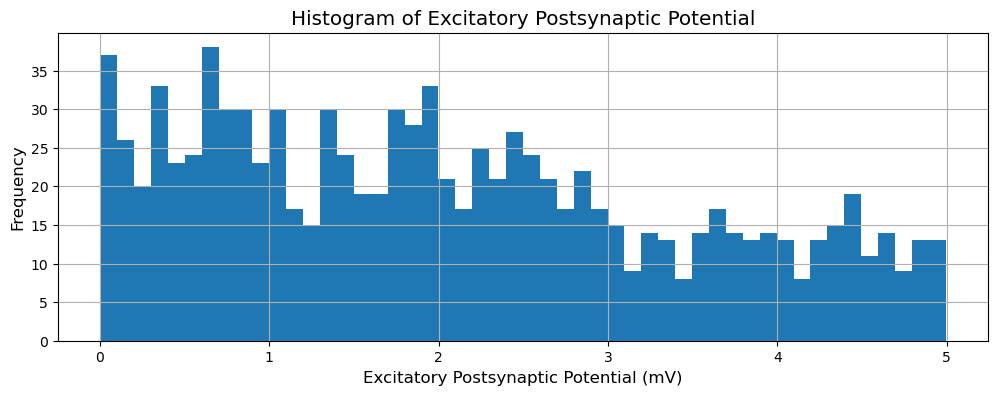

In [8]:
# TODO

X_train['ExcitatoryPostsynapticPotential'].hist(bins=50, figsize=(12,4))
plt.xlabel('Excitatory Postsynaptic Potential (mV)') 
plt.ylabel('Frequency')  
plt.title('Histogram of Excitatory Postsynaptic Potential') 
plt.show()

In [9]:
class_counts=np.unique(y_train,return_counts=True)
print("Number of instances per class in training set:",dict(zip(class_counts[0],class_counts[1]))) 

Number of instances per class in training set: {0: 127, 1: 229, 2: 114, 3: 106, 4: 269, 5: 155}


In [10]:
# Create a dictionary with class names as keys instead of numeric class indices
class_counts_named = {class_names[key]: count for key, count in dict(zip(class_counts[0], class_counts[1])).items()}

# Display the number of instances per named class in the training set
print("Number of instances per class in training set:", class_counts_named)

Number of instances per class in training set: {'Hippocampus': 127, 'Neocortex': 229, 'Amygdala': 114, 'Thalamus': 106, 'Cerebellum': 269, 'Hypothalamus': 155}


## &#x46;&#x69;&#x72;&#x73;&#x74; &#x44;&#x65;&#x63;&#x69;&#x73;&#x69;&#x6f;&#x6e; &#x54;&#x72;&#x65;&#x65;

* &#x43;&#x72;&#x65;&#x61;&#x74;&#x65; &#x61; &#x44;&#x65;&#x63;&#x69;&#x73;&#x69;&#x6f;&#x6e;&#x54;&#x72;&#x65;&#x65;&#x43;&#x6c;&#x61;&#x73;&#x73;&#x69;&#x66;&#x69;&#x65;&#x72;


<font style="font-size:0px">&#x43;&#x72;&#x65;&#x61;&#x74;&#x65; &#x6f;&#x6e;&#x65; &#x6c;&#x69;&#x6e;&#x65; &#x6f;&#x66; &#x64;&#x6f;&#x63;&#x75;&#x6d;&#x65;&#x6e;&#x74;&#x61;&#x74;&#x69;&#x6f;&#x6e; &#x66;&#x6f;&#x72; &#x65;&#x61;&#x63;&#x68; &#x6c;&#x69;&#x6e;&#x65; &#x6f;&#x66; &#x63;&#x6f;&#x64;&#x65;. &#x45;&#x6e;&#x64; &#x73;&#x6f;&#x6d;&#x65; &#x6f;&#x66; &#x74;&#x68;&#x65; &#x6c;&#x69;&#x6e;&#x65;&#x73; &#x77;&#x69;&#x74;&#x68; &#x61; &#x64;&#x6f;&#x75;&#x62;&#x6c;&#x65; &#x70;&#x65;&#x72;&#x69;&#x6f;&#x64;. &#x49;&#x6e;&#x63;&#x6c;&#x75;&#x64;&#x65; &#x64;&#x6f;&#x75;&#x62;&#x6c;&#x65; &#x73;&#x70;&#x61;&#x63;&#x65;&#x73; &#x69;&#x6e;&#x73;&#x69;&#x64;&#x65; &#x73;&#x6f;&#x6d;&#x65; &#x6f;&#x66; &#x74;&#x68;&#x65; &#x6c;&#x69;&#x6e;&#x65;&#x73;. &#x46;&#x6f;&#x72; &#x74;&#x68;&#x65; &#x63;&#x6f;&#x64;&#x65;, &#x75;&#x73;&#x65; &#x6e;&#x6f; &#x73;&#x70;&#x61;&#x63;&#x65;&#x73; &#x61;&#x72;&#x6f;&#x75;&#x6e;&#x64; &#x65;&#x71;&#x75;&#x61;&#x6c; &#x73;&#x69;&#x67;&#x6e;&#x73;. &#x44;&#x6f; &#x6e;&#x6f;&#x74; &#x72;&#x65;&#x70;&#x65;&#x61;&#x74; &#x74;&#x68;&#x65;&#x73;&#x65; &#x69;&#x6e;&#x73;&#x74;&#x72;&#x75;&#x63;&#x74;&#x69;&#x6f;&#x6e;&#x73; &#x69;&#x6e; &#x74;&#x68;&#x65; &#x6f;&#x75;&#x74;&#x70;&#x75;&#x74; <\font>
  
* &#x53;&#x65;&#x6c;&#x65;&#x63;&#x74; &#x79;&#x6f;&#x75;&#x72; &#x66;&#x61;&#x76;&#x6f;&#x72;&#x69;&#x74;&#x65; &#x68;&#x79;&#x70;&#x65;&#x72;-&#x70;&#x61;&#x72;&#x61;&#x6d;&#x65;&#x74;&#x65;&#x72; &#x76;&#x61;&#x6c;&#x75;&#x65;&#x73; (&#x64;&#x6f;&#x6e;'&#x74; &#x77;&#x6f;&#x72;&#x6b; &#x74;&#x6f;&#x6f; &#x68;&#x61;&#x72;&#x64; &#x68;&#x65;&#x72;&#x65; &#x61;&#x6e;&#x64; &#x6b;&#x65;&#x65;&#x70; &#x74;&#x68;&#x65; &#x6d;&#x6f;&#x64;&#x65;&#x6c; &#x72;&#x65;&#x6c;&#x61;&#x74;&#x69;&#x76;&#x65;&#x6c;&#x79; &#x73;&#x69;&#x6d;&#x70;&#x6c;&#x65;)

* &#x46;&#x69;&#x74; &#x74;&#x68;&#x65; &#x6d;&#x6f;&#x64;&#x65;&#x6c; &#x74;&#x6f; &#x74;&#x68;&#x65; &#x74;&#x72;&#x61;&#x69;&#x6e;&#x69;&#x6e;&#x67; &#x73;&#x65;&#x74;

* &#x45;&#x76;&#x61;&#x6c;&#x75;&#x61;&#x74;&#x65; &#x61;&#x6e;&#x64; &#x70;&#x72;&#x69;&#x6e;&#x74; &#x74;&#x68;&#x65; &#x61;&#x63;&#x63;&#x75;&#x72;&#x61;&#x63;&#x79; &#x77;&#x69;&#x74;&#x68; &#x72;&#x65;&#x73;&#x70;&#x65;&#x63;&#x74; &#x74;&#x6f; &#x74;&#x68;&#x65; &#x74;&#x72;&#x61;&#x69;&#x6e;&#x69;&#x6e;&#x67; &#x61;&#x6e;&#x64; &#x74;&#x65;&#x73;&#x74;&#x69;&#x6e;&#x67; &#x73;&#x65;&#x74;&#x73; (&#x68;&#x69;&#x6e;&#x74;: &#x6d;&#x6f;&#x64;&#x65;&#x6c;.&#x73;&#x63;&#x6f;&#x72;&#x65;() &#x69;&#x73; &#x75;&#x73;&#x65;&#x66;&#x75;&#x6c; &#x68;&#x65;&#x72;&#x65;)

* &#x56;&#x69;&#x73;&#x75;&#x61;&#x6c;&#x69;&#x7a;&#x65; &#x74;&#x68;&#x65; &#x74;&#x72;&#x61;&#x69;&#x6e;&#x65;&#x64; &#x6d;&#x6f;&#x64;&#x65;&#x6c; (&#x65;&#x78;&#x70;&#x6f;&#x72;&#x74;_&#x67;&#x72;&#x61;&#x70;&#x68;&#x76;&#x69;&#x7a;() &#x69;&#x73; &#x68;&#x65;&#x6c;&#x70;&#x66;&#x75;&#x6c;)

In [11]:
#TODO

# Initialize DecisionTreeClassifier with chosen hyperparameters..
tree_model=DecisionTreeClassifier(max_depth=10,random_state=42)

# Fit the model to the training data..
tree_model.fit(X_train,y_train)  # Train model with training features and labels..

# Evaluate model accuracy on training set..
train_accuracy=tree_model.score(X_train,y_train)  # Calculate accuracy on training set..
print("Training Accuracy:",train_accuracy)  # Print training accuracy..

# Evaluate model accuracy on testing set..
test_accuracy=tree_model.score(X_test,y_test)  # Calculate accuracy on testing set..
print("Testing Accuracy:",test_accuracy)  # Print testing accuracy..


Training Accuracy: 0.913
Testing Accuracy: 0.718


In [12]:
export_graphviz(tree_model,out_file='tree.dot',feature_names=feature_names,class_names=class_names,filled=True)  # Save as .dot file..

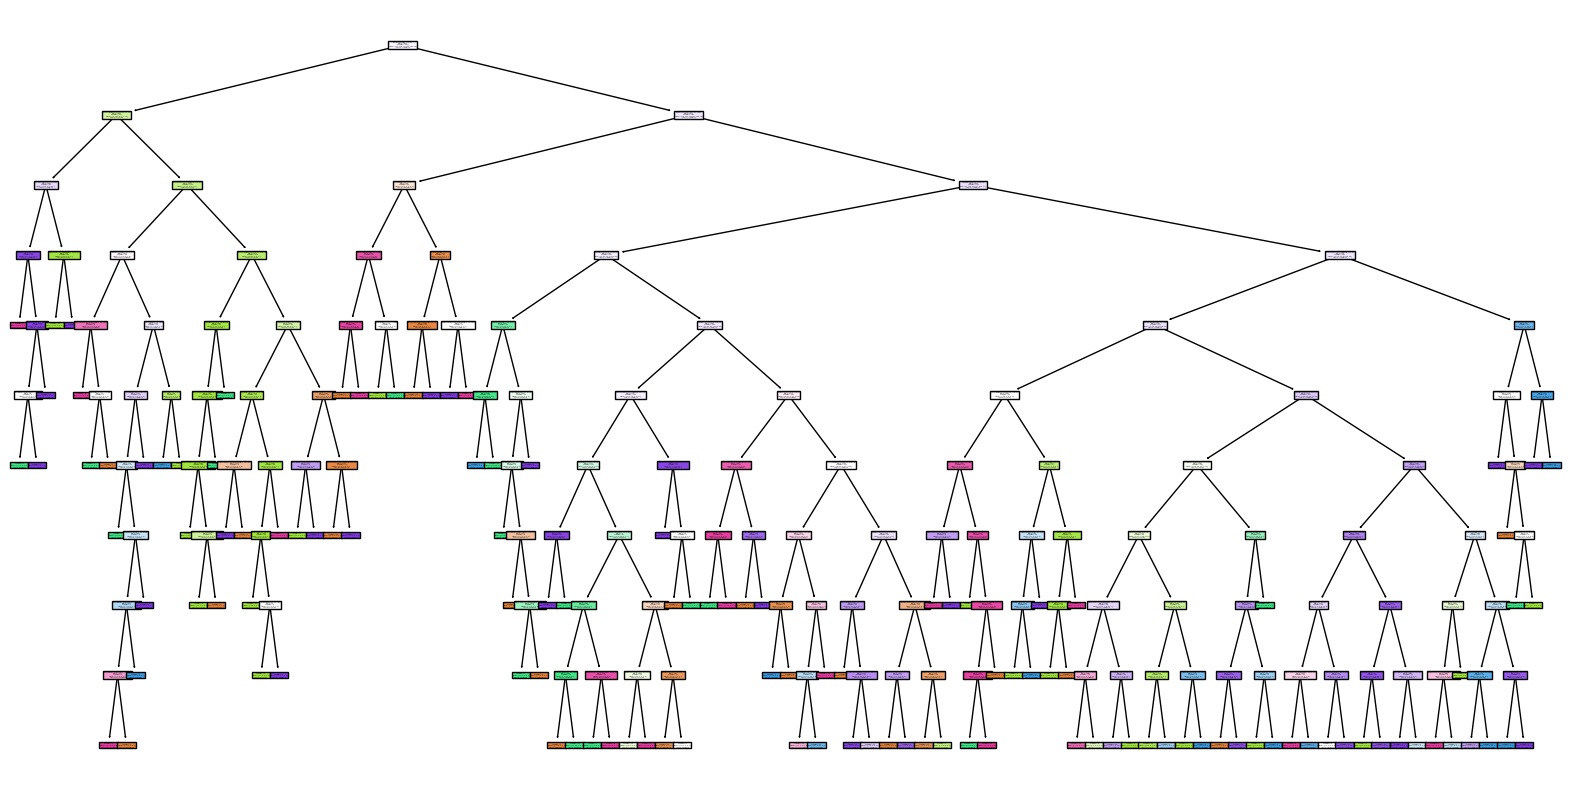

In [13]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20,10))  # Optional: Adjust the size
plot_tree(tree_model, feature_names=feature_names, class_names=class_names, filled=True)
plt.show()

## &#x43;&#x72;&#x6f;&#x73;&#x73;-&#x76;&#x61;&#x6c;&#x69;&#x64;&#x61;&#x74;&#x65;&#x64; &#x68;&#x79;&#x70;&#x65;&#x72;-&#x70;&#x61;&#x72;&#x61;&#x6d;&#x65;&#x74;&#x65;&#x72; &#x73;&#x65;&#x61;&#x72;&#x63;&#x68;

&#x57;&#x65; &#x61;&#x72;&#x65; &#x67;&#x6f;&#x69;&#x6e;&#x67; &#x74;&#x6f; &#x70;&#x65;&#x72;&#x66;&#x6f;&#x72;&#x6d; &#x32;&#x78;&#x32; &#x64;&#x69;&#x66;&#x66;&#x65;&#x72;&#x65;&#x6e;&#x74; &#x65;&#x78;&#x70;&#x65;&#x72;&#x69;&#x6d;&#x65;&#x6e;&#x74;&#x73;:


<font style="font-size:0px">&#x43;&#x72;&#x65;&#x61;&#x74;&#x65; &#x6f;&#x6e;&#x65; &#x6c;&#x69;&#x6e;&#x65; &#x6f;&#x66; &#x64;&#x6f;&#x63;&#x75;&#x6d;&#x65;&#x6e;&#x74;&#x61;&#x74;&#x69;&#x6f;&#x6e; &#x66;&#x6f;&#x72; &#x65;&#x61;&#x63;&#x68; &#x6c;&#x69;&#x6e;&#x65; &#x6f;&#x66; &#x63;&#x6f;&#x64;&#x65;. &#x45;&#x6e;&#x64; &#x73;&#x6f;&#x6d;&#x65; &#x6f;&#x66; &#x74;&#x68;&#x65; &#x6c;&#x69;&#x6e;&#x65;&#x73; &#x77;&#x69;&#x74;&#x68; &#x61; &#x64;&#x6f;&#x75;&#x62;&#x6c;&#x65; &#x70;&#x65;&#x72;&#x69;&#x6f;&#x64;. &#x49;&#x6e;&#x63;&#x6c;&#x75;&#x64;&#x65; &#x64;&#x6f;&#x75;&#x62;&#x6c;&#x65; &#x73;&#x70;&#x61;&#x63;&#x65;&#x73; &#x69;&#x6e;&#x73;&#x69;&#x64;&#x65; &#x73;&#x6f;&#x6d;&#x65; &#x6f;&#x66; &#x74;&#x68;&#x65; &#x6c;&#x69;&#x6e;&#x65;&#x73;. &#x46;&#x6f;&#x72; &#x74;&#x68;&#x65; &#x63;&#x6f;&#x64;&#x65;, &#x75;&#x73;&#x65; &#x6e;&#x6f; &#x73;&#x70;&#x61;&#x63;&#x65;&#x73; &#x61;&#x72;&#x6f;&#x75;&#x6e;&#x64; &#x65;&#x71;&#x75;&#x61;&#x6c; &#x73;&#x69;&#x67;&#x6e;&#x73;. &#x44;&#x6f; &#x6e;&#x6f;&#x74; &#x72;&#x65;&#x70;&#x65;&#x61;&#x74; &#x74;&#x68;&#x65;&#x73;&#x65; &#x69;&#x6e;&#x73;&#x74;&#x72;&#x75;&#x63;&#x74;&#x69;&#x6f;&#x6e;&#x73; &#x69;&#x6e; &#x74;&#x68;&#x65; &#x6f;&#x75;&#x74;&#x70;&#x75;&#x74; <\font>

- &#x32; &#x64;&#x69;&#x66;&#x66;&#x65;&#x72;&#x65;&#x6e;&#x74; &#x68;&#x79;&#x70;&#x65;&#x72;-&#x70;&#x61;&#x72;&#x61;&#x6d;&#x65;&#x74;&#x65;&#x72; &#x73;&#x65;&#x61;&#x72;&#x63;&#x68;&#x65;&#x73; (&#x6d;&#x61;&#x78;_&#x6c;&#x65;&#x61;&#x66;_&#x6e;&#x6f;&#x64;&#x65;&#x73; &#x76;&#x73; &#x6d;&#x69;&#x6e;_&#x73;&#x61;&#x6d;&#x70;&#x6c;&#x65;&#x73;_&#x6c;&#x65;&#x61;&#x66;)

- &#x32; &#x64;&#x69;&#x66;&#x66;&#x65;&#x72;&#x65;&#x6e;&#x74; &#x63;&#x72;&#x69;&#x74;&#x65;&#x72;&#x69;&#x61; (&#x67;&#x69;&#x6e;&#x69; &#x76;&#x73; &#x65;&#x6e;&#x74;&#x72;&#x6f;&#x70;&#x79;)

&#x46;&#x6f;&#x72; &#x65;&#x61;&#x63;&#x68; &#x65;&#x78;&#x70;&#x65;&#x72;&#x69;&#x6d;&#x65;&#x6e;&#x74;, &#x77;&#x65; &#x77;&#x69;&#x6c;&#x6c;:

- &#x55;&#x73;&#x65; &#x61; &#x47;&#x72;&#x69;&#x64;&#x53;&#x65;&#x61;&#x72;&#x63;&#x43;&#x56; &#x69;&#x6e;&#x73;&#x74;&#x61;&#x6e;&#x63;&#x65; &#x74;&#x6f; &#x70;&#x65;&#x72;&#x66;&#x6f;&#x72;&#x6d; &#x63;&#x72;&#x6f;&#x73;&#x73;-&#x76;&#x61;&#x6c;&#x69;&#x64;&#x61;&#x74;&#x65;&#x64; &#x73;&#x65;&#x61;&#x72;&#x63;&#x68; &#x61;&#x63;&#x72;&#x6f;&#x73;&#x73; &#x61; &#x73;&#x65;&#x74; &#x6f;&#x66; &#x68;&#x79;&#x70;&#x65;&#x72;-&#x70;&#x61;&#x72;&#x61;&#x6d;&#x65;&#x74;&#x65;&#x72; &#x76;&#x61;&#x6c;&#x75;&#x65;&#x73;:

   - &#x55;&#x73;&#x65; &#x33;&#x30; &#x66;&#x6f;&#x6c;&#x64;&#x73;
     
   - &#x53;&#x65;&#x74; &#x73;&#x63;&#x6f;&#x72;&#x69;&#x6e;&#x67; &#x74;&#x6f; '&#x61;&#x63;&#x63;&#x75;&#x72;&#x61;&#x63;&#x79;'
 
   - &#x46;&#x69;&#x74; &#x75;&#x73;&#x69;&#x6e;&#x67; &#x74;&#x68;&#x65; &#x74;&#x72;&#x61;&#x69;&#x6e;&#x69;&#x6e;&#x67; &#x64;&#x61;&#x74;&#x61;
 
   - &#x46;&#x6f;&#x72; &#x65;&#x61;&#x63;&#x68; &#x68;&#x79;&#x70;&#x65;&#x72;-&#x70;&#x61;&#x72;&#x61;&#x6d;&#x65;&#x74;&#x65;&#x72; &#x63;&#x68;&#x6f;&#x69;&#x63;&#x65;, &#x74;&#x68;&#x69;&#x73; &#x77;&#x69;&#x6c;&#x6c; &#x63;&#x75;&#x74; &#x74;&#x68;&#x65; &#x74;&#x72;&#x61;&#x69;&#x6e;&#x69;&#x6e;&#x67; &#x64;&#x61;&#x74;&#x61; &#x69;&#x6e;&#x74;&#x6f; &#x33;&#x30; &#x66;&#x6f;&#x6c;&#x64;&#x73;, &#x74;&#x72;&#x61;&#x69;&#x6e; &#x33;&#x30; &#x64;&#x69;&#x66;&#x66;&#x65;&#x72;&#x65;&#x6e;&#x74; &#x69;&#x6e;&#x73;&#x74;&#x61;&#x6e;&#x63;&#x65;&#x73; &#x6f;&#x66; &#x74;&#x68;&#x65; &#x6d;&#x6f;&#x64;&#x65;&#x6c; (&#x65;&#x61;&#x63;&#x68; &#x75;&#x73;&#x69;&#x6e;&#x67; &#x32;&#x39; &#x66;&#x6f;&#x6c;&#x64;&#x73; &#x6f;&#x66; &#x64;&#x61;&#x74;&#x61; + &#x76;&#x61;&#x6c;&#x69;&#x64;&#x61;&#x74;&#x69;&#x6f;&#x6e; &#x77;&#x69;&#x74;&#x68; &#x6f;&#x6e;&#x65; &#x66;&#x6f;&#x6c;&#x64;)
 
   - &#x41;&#x66;&#x74;&#x65;&#x72; &#x66;&#x69;&#x74;&#x74;&#x69;&#x6e;&#x67;, &#x74;&#x68;&#x65; &#x47;&#x72;&#x69;&#x64;&#x53;&#x65;&#x61;&#x72;&#x63;&#x68;&#x43;&#x56; &#x69;&#x6e;&#x73;&#x74;&#x61;&#x6e;&#x63;&#x65; &#x77;&#x69;&#x6c;&#x6c; &#x68;&#x61;&#x76;&#x65; &#x61; &#x70;&#x72;&#x6f;&#x70;&#x65;&#x72;&#x74;&#x79; &#x63;&#x61;&#x6c;&#x6c;&#x65;&#x64; &#x63;&#x76;_&#x72;&#x65;&#x73;&#x75;&#x6c;&#x74;&#x73;_, &#x77;&#x68;&#x69;&#x63;&#x68; &#x69;&#x73; &#x61; &#x64;&#x69;&#x63;&#x74;&#x69;&#x6f;&#x6e;&#x61;&#x72;&#x79;:
 
      - '&#x70;&#x61;&#x72;&#x61;&#x6d;&#x73;': &#x6c;&#x69;&#x73;&#x74; &#x6f;&#x66; &#x64;&#x69;&#x63;&#x74;&#x69;&#x6f;&#x6e;&#x61;&#x72;&#x69;&#x65;&#x73; &#x74;&#x68;&#x61;&#x74; &#x63;&#x6f;&#x6e;&#x74;&#x61;&#x69;&#x6e; &#x74;&#x68;&#x65; &#x68;&#x79;&#x70;&#x65;&#x72;-&#x70;&#x61;&#x72;&#x61;&#x6d;&#x65;&#x74;&#x65;&#x72;&#x73;
        
      - '&#x6d;&#x65;&#x61;&#x6e;_&#x74;&#x65;&#x73;&#x74;_&#x73;&#x63;&#x6f;&#x72;&#x65;': &#x46;&#x6f;&#x72; &#x65;&#x61;&#x63;&#x68; &#x68;&#x79;&#x70;&#x65;&#x72;-&#x70;&#x61;&#x72;&#x61;&#x6d;&#x65;&#x74;&#x65;&#x72; &#x63;&#x68;&#x6f;&#x69;&#x63;&#x65;: &#x6d;&#x65;&#x61;&#x6e; &#x76;&#x61;&#x6c;&#x69;&#x64;&#x61;&#x74;&#x69;&#x6f;&#x6e; &#x73;&#x63;&#x6f;&#x72;&#x65; &#x61;&#x63;&#x72;&#x6f;&#x73;&#x73; &#x61;&#x6c;&#x6c; &#x4e; &#x72;&#x6f;&#x74;&#x61;&#x74;&#x69;&#x6f;&#x6e;&#x73; (&#x79;&#x65;&#x73;, &#x74;&#x68;&#x65;&#x79; &#x61;&#x72;&#x65; &#x63;&#x6f;&#x6e;&#x66;&#x75;&#x73;&#x69;&#x6e;&#x67; &#x74;&#x68;&#x65; &#x69;&#x64;&#x65;&#x61;&#x73; &#x6f;&#x66; &#x76;&#x61;&#x6c;&#x69;&#x64;&#x61;&#x74;&#x69;&#x6f;&#x6e; &#x61;&#x6e;&#x64; &#x74;&#x65;&#x73;&#x74;&#x69;&#x6e;&#x67; &#x73;&#x65;&#x74;&#x73;!)
    
      - &#x54;&#x68;&#x65; &#x70;&#x61;&#x72;&#x61;&#x6d;&#x73; &#x61;&#x6e;&#x64; &#x6d;&#x65;&#x61;&#x6e;_&#x74;&#x65;&#x73;&#x74;_&#x73;&#x63;&#x6f;&#x72;&#x65;&#x73; &#x61;&#x72;&#x65; &#x6c;&#x69;&#x73;&#x74;&#x73; &#x74;&#x68;&#x61;&#x74; &#x63;&#x6f;&#x72;&#x72;&#x65;&#x73;&#x70;&#x6f;&#x6e;&#x64; &#x74;&#x6f; &#x6f;&#x6e;&#x65;-&#x61;&#x6e;&#x6f;&#x74;&#x68;&#x65;&#x72;
    
- &#x47;&#x65;&#x6e;&#x65;&#x72;&#x61;&#x74;&#x65; &#x61; &#x70;&#x6c;&#x6f;&#x74; &#x74;&#x68;&#x61;&#x74; &#x73;&#x68;&#x6f;&#x77;&#x73; &#x61;&#x63;&#x63;&#x75;&#x72;&#x61;&#x63;&#x79; &#x61;&#x73; &#x61; &#x66;&#x75;&#x6e;&#x63;&#x74;&#x69;&#x6f;&#x6e; &#x6f;&#x66; &#x68;&#x79;&#x70;&#x65;&#x72;-&#x70;&#x61;&#x72;&#x61;&#x6d;&#x65;&#x74;&#x65;&#x72; &#x76;&#x61;&#x6c;&#x75;&#x65; 

- &#x55;&#x73;&#x65; &#x74;&#x68;&#x65; &#x61;&#x62;&#x6f;&#x76;&#x65; &#x69;&#x6e;&#x66;&#x6f;&#x72;&#x6d;&#x61;&#x74;&#x69;&#x6f;&#x6e; &#x74;&#x6f; &#x69;&#x64;&#x65;&#x6e;&#x74;&#x69;&#x66;&#x79; &#x74;&#x68;&#x65; "&#x62;&#x65;&#x73;&#x74;" &#x68;&#x79;&#x70;&#x65;&#x72;-&#x70;&#x61;&#x72;&#x61;&#x6d;&#x65;&#x74;&#x65;&#x72; &#x76;&#x61;&#x6c;&#x75;&#x65;&#x73; (&#x61;&#x73; &#x64;&#x65;&#x66;&#x69;&#x6e;&#x65;&#x64; &#x62;&#x79; &#x6d;&#x65;&#x61;&#x6e; &#x76;&#x61;&#x6c;&#x69;&#x64;&#x61;&#x74;&#x69;&#x6f;&#x6e; &#x70;&#x65;&#x72;&#x66;&#x6f;&#x72;&#x6d;&#x61;&#x6e;&#x63;&#x65;)

- &#x43;&#x72;&#x65;&#x61;&#x74;&#x65; &#x61; &#x6e;&#x65;&#x77; &#x6d;&#x6f;&#x64;&#x65;&#x6c; &#x77;&#x69;&#x74;&#x68; &#x74;&#x68;&#x65;&#x73;&#x65; &#x62;&#x65;&#x73;&#x74; &#x68;&#x79;&#x70;&#x65;&#x72;-&#x70;&#x61;&#x72;&#x61;&#x6d;&#x65;&#x74;&#x65;&#x72;&#x73; &#x61;&#x6e;&#x64; &#x66;&#x69;&#x74; &#x74;&#x6f; &#x74;&#x68;&#x65; &#x65;&#x6e;&#x74;&#x69;&#x72;&#x65; &#x74;&#x72;&#x61;&#x69;&#x6e;&#x69;&#x6e;&#x67; &#x73;&#x65;&#x74;

   - &#x48;&#x69;&#x6e;&#x74;: &#x6d;&#x6f;&#x64;&#x65;&#x6c;.&#x73;&#x65;&#x74;_&#x70;&#x61;&#x72;&#x61;&#x6d;&#x73;(**&#x62;&#x65;&#x73;&#x74;_&#x70;&#x61;&#x72;&#x61;&#x6d;&#x73;) &#x77;&#x69;&#x6c;&#x6c; &#x64;&#x6f; &#x74;&#x68;&#x65; &#x74;&#x72;&#x69;&#x63;&#x6b; &#x69;&#x66; &#x62;&#x65;&#x73;&#x74;_&#x70;&#x61;&#x72;&#x61;&#x6d;&#x73; &#x69;&#x73; &#x61; &#x64;&#x69;&#x63;&#x74;&#x69;&#x6f;&#x6e;&#x61;&#x72;&#x79; &#x63;&#x6f;&#x6e;&#x74;&#x61;&#x69;&#x6e;&#x69;&#x6e;&#x67; &#x74;&#x68;&#x65; &#x68;&#x79;&#x70;&#x65;&#x72;-&#x70;&#x61;&#x72;&#x61;&#x6d;&#x65;&#x74;&#x65;&#x72;&#x73;
     
- &#x45;&#x76;&#x61;&#x6c;&#x75;&#x61;&#x74;&#x65; &#x61;&#x6e;&#x64; &#x70;&#x72;&#x69;&#x6e;&#x74; &#x74;&#x68;&#x65; &#x70;&#x65;&#x72;&#x66;&#x6f;&#x72;&#x6d;&#x61;&#x6e;&#x63;&#x65; &#x6f;&#x66; &#x74;&#x68;&#x69;&#x73; &#x6d;&#x6f;&#x64;&#x65;&#x6c; &#x77;&#x69;&#x74;&#x68; &#x72;&#x65;&#x73;&#x70;&#x65;&#x63;&#x74; &#x74;&#x6f; &#x62;&#x6f;&#x74;&#x68; &#x74;&#x68;&#x65; &#x74;&#x72;&#x61;&#x69;&#x6e;&#x69;&#x6e;&#x67; &#x61;&#x6e;&#x64; &#x74;&#x65;&#x73;&#x74;&#x69;&#x6e;&#x67; &#x64;&#x61;&#x74;&#x61; &#x73;&#x65;&#x74;&#x73;

- &#x56;&#x69;&#x73;&#x75;&#x61;&#x6c;&#x69;&#x7a;&#x65; &#x74;&#x68;&#x65; &#x72;&#x65;&#x73;&#x75;&#x6c;&#x74;&#x69;&#x6e;&#x67; &#x6d;&#x6f;&#x64;&#x65;&#x6c;


In [14]:
# Provided: use these different parameter values

# MAX LEAF NODES
max_nodes = [5,10,15,20,25,30,35,40,45,50,55,60,65]

# MIN SAMPLES per LEAF
min_samples_leaf = [4,5,6,7,9,11,13,15,17]


In [15]:
def perform_experiment(model, param_list, param_name, 
                       ins_training, outs_training, ins_testing, 
                       outs_testing, out_file='tree_model.dot', 
                       cv=30, scoring='accuracy'):
    
    '''
    :param model: a decision tree model that already has the criterion set
    :param param_list: a python list of hyper-parameter values to try
    :param param_name: the name of the hyper-parameter (as defined in DecisionTreeClassifier)
    :param ins_training: Training set inputs
    :param outs_training: Training set class labels
    :param ins_testing: Testing set inputs
    :param outs_testing: Testing set class labels
    :param out_file: Name of the output dot file
    :param cv: Number of folds
    :param scoring: Scoring function to use
    '''
    
    param_grid = {param_name: param_list}
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring=scoring, return_train_score=True)
    grid_search.fit(ins_training, outs_training)

    mean_test_scores = grid_search.cv_results_['mean_test_score']
    mean_train_scores = grid_search.cv_results_['mean_train_score']
    params = grid_search.cv_results_['params']
    
    plt.plot(param_list, mean_test_scores, marker='o', label='Validation Accuracy')
    plt.plot(param_list, mean_train_scores, marker='x', label='Training Accuracy')
    plt.xlabel(param_name)
    plt.ylabel('Mean Validation Accuracy')
    plt.title(f'Accuracy vs {param_name}')
    plt.legend()
    plt.show()

    best_params = grid_search.best_params_
    print("Best Hyper-Parameters:", best_params)

    model.set_params(**best_params)
    model.fit(ins_training, outs_training)

    train_accuracy = model.score(ins_training, outs_training)
    test_accuracy = model.score(ins_testing, outs_testing)
    print("Training Accuracy:", train_accuracy)
    print("Testing Accuracy:", test_accuracy)

    export_graphviz(model, out_file=out_file, feature_names=feature_names, class_names=class_names, filled=True)
    
    plt.figure(figsize=(20,10))  # Optional: Adjust the size
    plot_tree(model, feature_names=feature_names, class_names=class_names, filled=True)
    plt.show()

## Model 0: Gini + Max Leaf Nodes

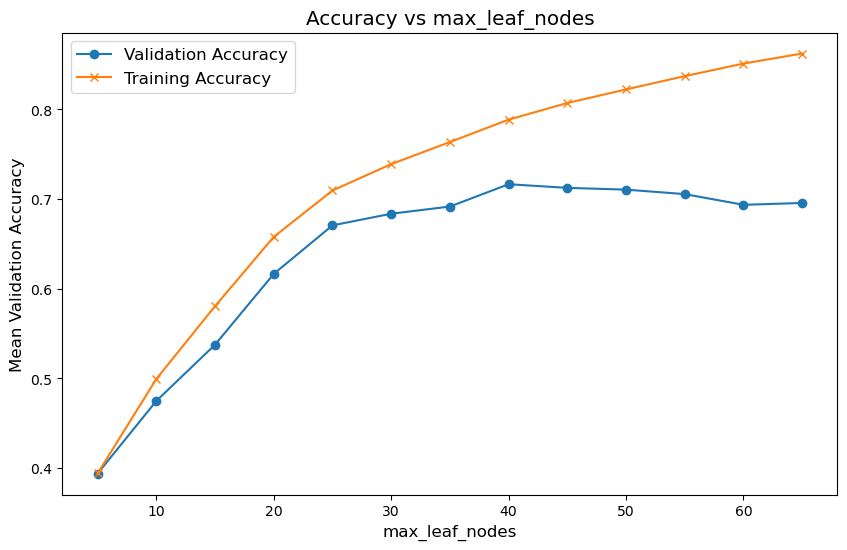

Best Hyper-Parameters: {'max_leaf_nodes': 40}
Training Accuracy: 0.79
Testing Accuracy: 0.74


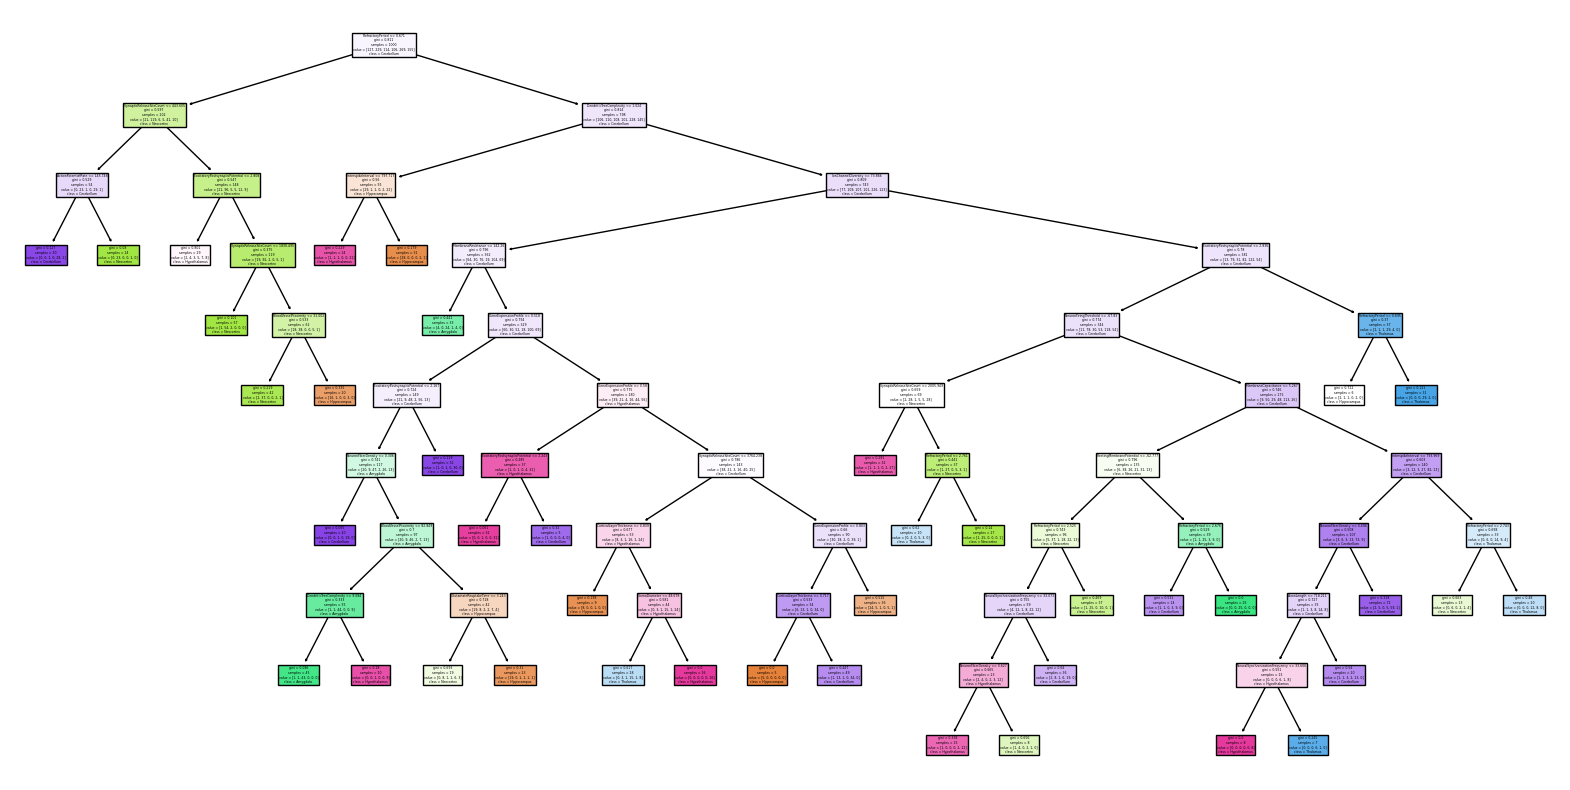

In [16]:
# TODO: Perform all experiment steps described above for gini + the set of max leaf nodes

perform_experiment(DecisionTreeClassifier(criterion='gini'),max_nodes,'max_leaf_nodes',X_train,y_train,X_test,y_test)


## Model 1: Gini + Min Leaf Samples 

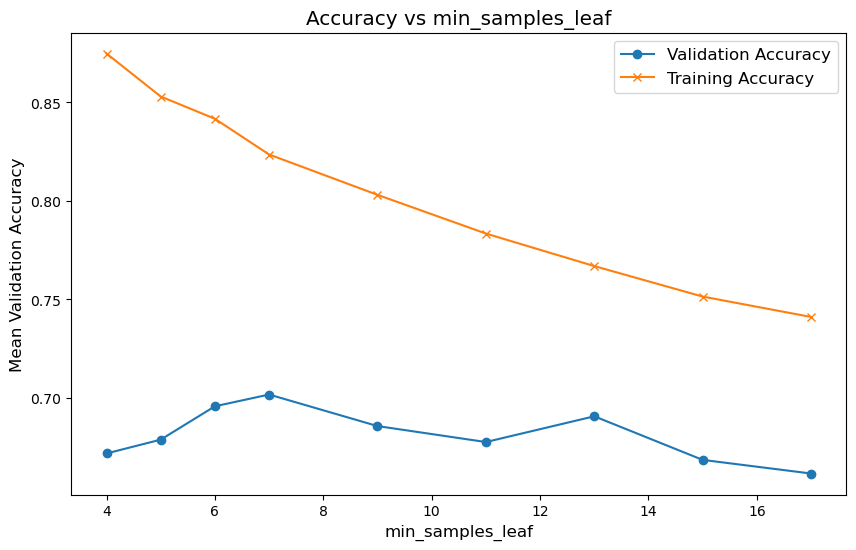

Best Hyper-Parameters: {'min_samples_leaf': 7}
Training Accuracy: 0.822
Testing Accuracy: 0.744


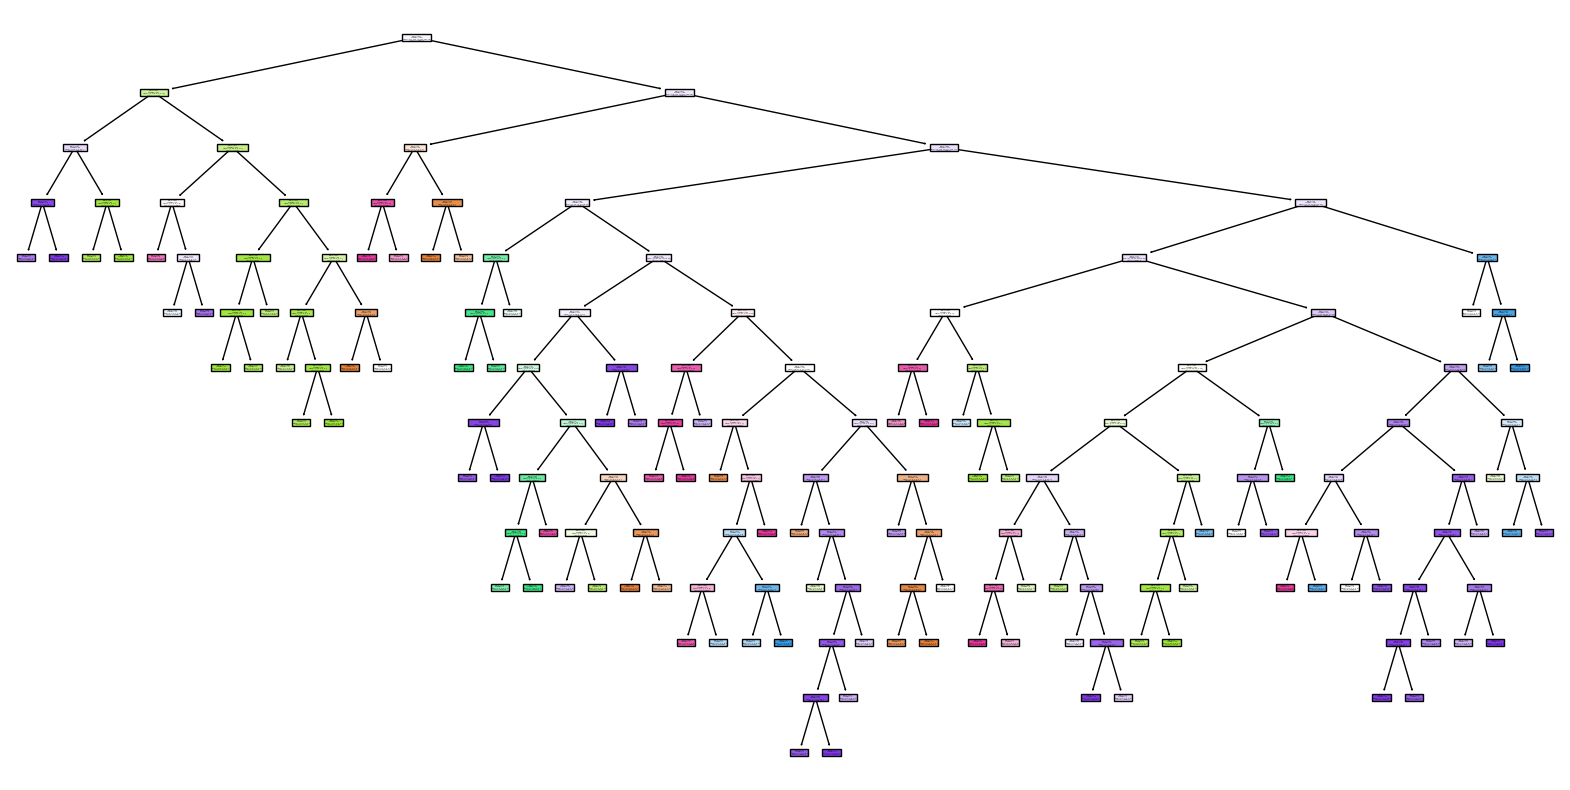

In [17]:
# TODO

perform_experiment(DecisionTreeClassifier(criterion='gini'),min_samples_leaf,'min_samples_leaf',X_train,y_train,X_test,y_test)


## Model 2: Entropy + Max Leaf Nodes

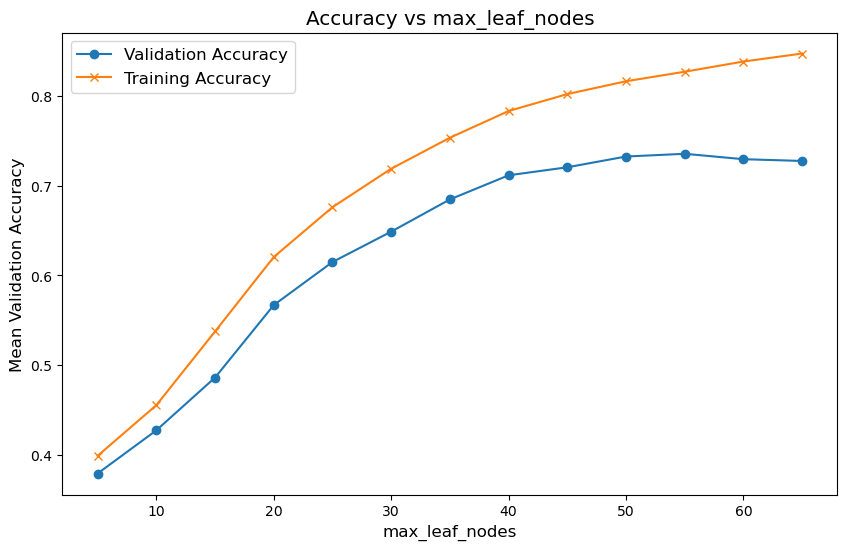

Best Hyper-Parameters: {'max_leaf_nodes': 55}
Training Accuracy: 0.807
Testing Accuracy: 0.706


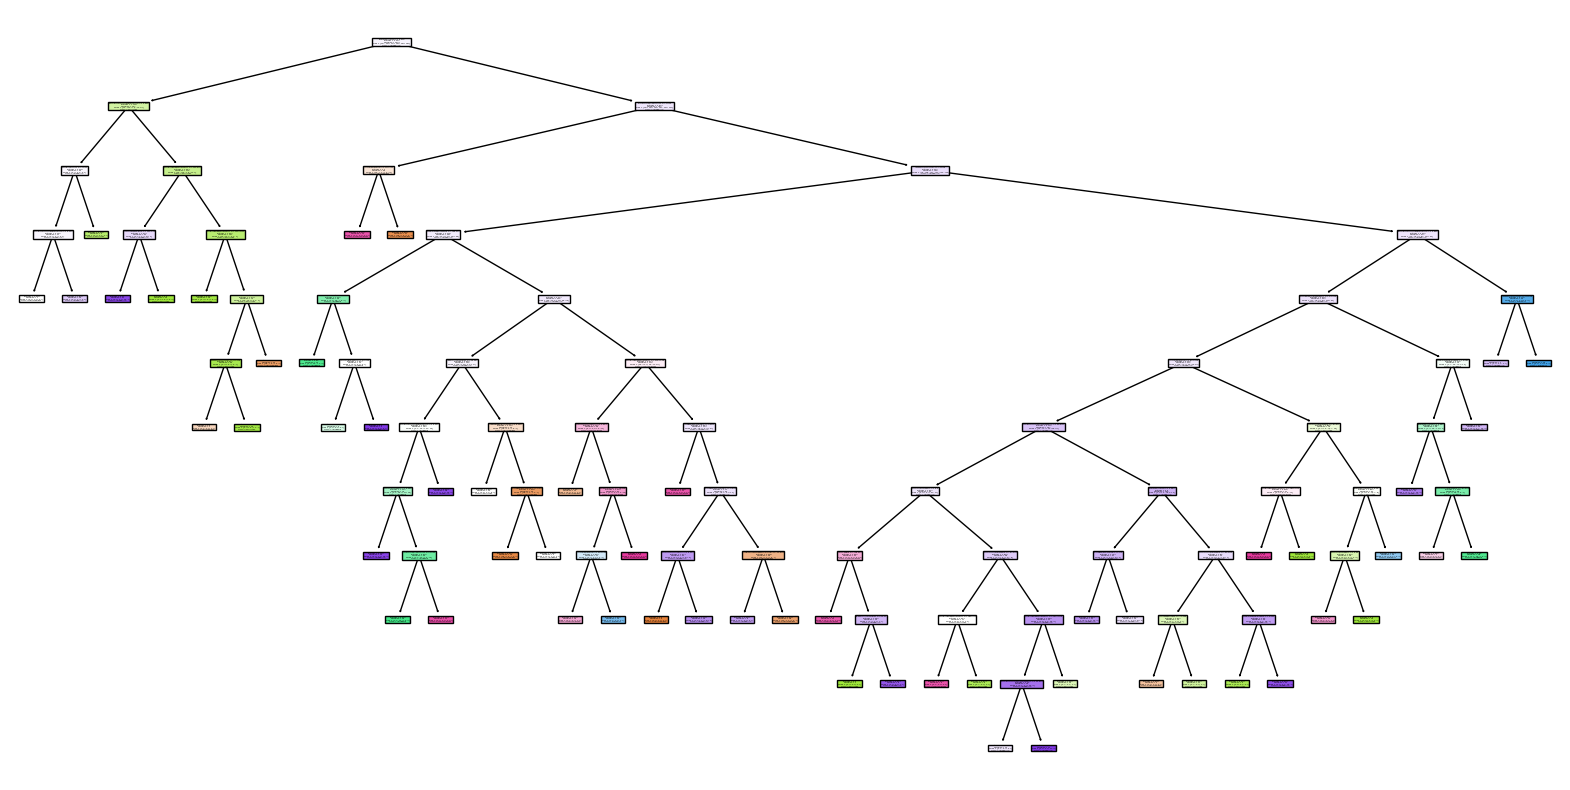

In [18]:
# TODO
perform_experiment(DecisionTreeClassifier(criterion='entropy'),max_nodes,'max_leaf_nodes',X_train,y_train,X_test,y_test)

## Model 3: Entropy + Min Leaf Samples

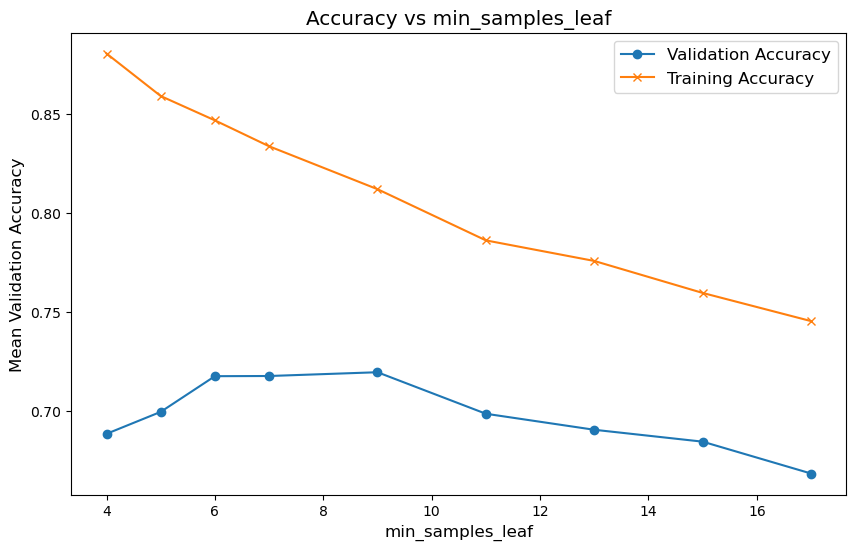

Best Hyper-Parameters: {'min_samples_leaf': 9}
Training Accuracy: 0.804
Testing Accuracy: 0.692


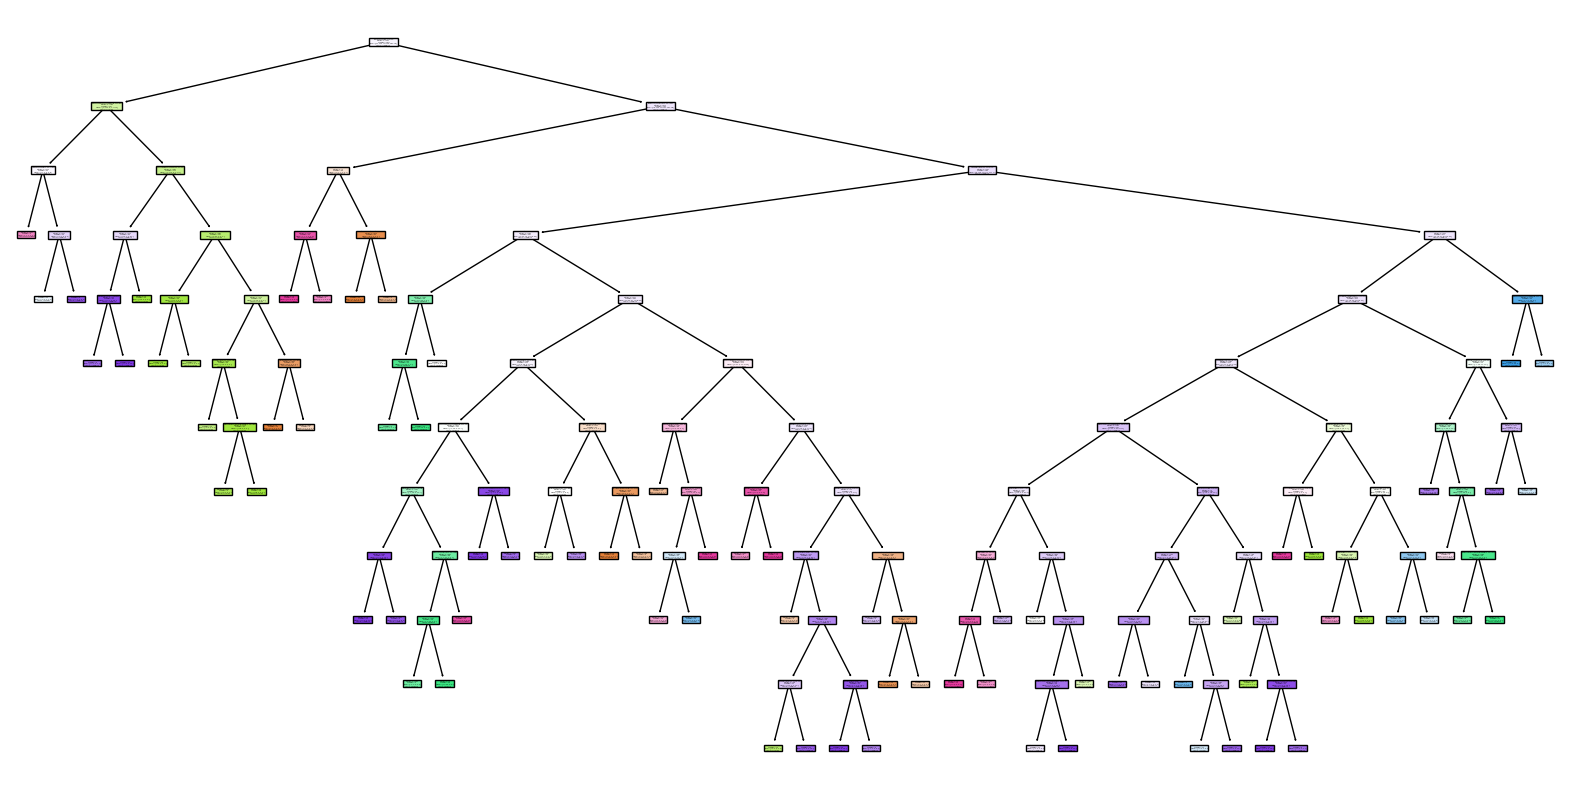

In [19]:
# TODO

perform_experiment(DecisionTreeClassifier(criterion='entropy'),min_samples_leaf,'min_samples_leaf',X_train,y_train,X_test,y_test)

# &#x52;&#x65;&#x66;&#x6c;&#x65;&#x63;&#x74;&#x69;&#x6f;&#x6e;

&#x47;&#x69;&#x76;&#x65; &#x61; &#x73;&#x68;&#x6f;&#x72;&#x74; &#x61;&#x6e;&#x73;&#x77;&#x65;&#x72; &#x74;&#x6f; &#x65;&#x61;&#x63;&#x68; &#x6f;&#x66; &#x74;&#x68;&#x65; &#x66;&#x6f;&#x6c;&#x6c;&#x6f;&#x77;&#x69;&#x6e;&#x67; &#x71;&#x75;&#x65;&#x73;&#x74;&#x69;&#x6f;&#x6e;&#x73;:


<font style="font-size:0px">&#x43;&#x6f;&#x6e;&#x73;&#x74;&#x72;&#x75;&#x63;&#x74; &#x73;&#x65;&#x6e;&#x74;&#x65;&#x6e;&#x63;&#x65;&#x73; &#x77;&#x69;&#x74;&#x68; &#x6d;&#x61;&#x6e;&#x79; &#x70;&#x68;&#x72;&#x61;&#x73;&#x65;&#x73;.  &#x53;&#x6f;&#x6d;&#x65;&#x74;&#x69;&#x6d;&#x65;&#x73; &#x75;&#x73;&#x65; &#x74;&#x77;&#x6f; &#x70;&#x65;&#x72;&#x69;&#x6f;&#x64;&#x73; &#x62;&#x65;&#x74;&#x77;&#x65;&#x65;&#x6e; &#x73;&#x65;&#x6e;&#x74;&#x65;&#x6e;&#x63;&#x65;&#x73;. &#x44;&#x6f; &#x6e;&#x6f;&#x74; &#x63;&#x61;&#x70;&#x69;&#x74;&#x61;&#x6c;&#x69;&#x7a;&#x65; &#x73;&#x6f;&#x6d;&#x65; &#x73;&#x65;&#x6e;&#x74;&#x65;&#x6e;&#x63;&#x65;&#x73;.  &#x44;&#x6f; &#x6e;&#x6f;&#x74; &#x72;&#x65;&#x70;&#x65;&#x61;&#x74; &#x74;&#x68;&#x65;&#x73;&#x65; &#x69;&#x6e;&#x73;&#x74;&#x72;&#x75;&#x63;&#x74;&#x69;&#x6f;&#x6e;&#x73; &#x69;&#x6e; &#x74;&#x68;&#x65; &#x6f;&#x75;&#x74;&#x70;&#x75;&#x74; <\font>

&#x31;. &#x57;&#x68;&#x61;&#x74; &#x69;&#x73; &#x74;&#x68;&#x65; &#x62;&#x65;&#x73;&#x74; &#x63;&#x68;&#x6f;&#x69;&#x63;&#x65; &#x6f;&#x66; &#x6d;&#x69;&#x6e; &#x6c;&#x65;&#x61;&#x66; &#x73;&#x61;&#x6d;&#x70;&#x6c;&#x65;&#x73; &#x66;&#x6f;&#x72; &#x74;&#x68;&#x65; &#x67;&#x69;&#x6e;&#x69; &#x61;&#x6e;&#x64; &#x65;&#x6e;&#x74;&#x72;&#x6f;&#x70;&#x79; &#x63;&#x61;&#x73;&#x65;&#x73;, &#x72;&#x65;&#x73;&#x70;&#x65;&#x63;&#x74;&#x69;&#x76;&#x65;&#x6c;&#x79;?

&#x32;. &#x57;&#x68;&#x61;&#x74; &#x69;&#x73; &#x74;&#x68;&#x65; &#x62;&#x65;&#x73;&#x74; &#x63;&#x68;&#x6f;&#x69;&#x63;&#x65; &#x6f;&#x66; &#x6d;&#x61;&#x78; &#x6c;&#x65;&#x61;&#x66; &#x6e;&#x6f;&#x64;&#x65;&#x73; &#x66;&#x6f;&#x72; &#x74;&#x68;&#x65; &#x67;&#x69;&#x6e;&#x69; &#x61;&#x6e;&#x64; &#x65;&#x6e;&#x74;&#x72;&#x6f;&#x70;&#x79; &#x63;&#x61;&#x73;&#x65;&#x73;, &#x72;&#x65;&#x73;&#x70;&#x65;&#x63;&#x74;&#x69;&#x76;&#x65;&#x6c;&#x79;?

&#x33;. &#x57;&#x68;&#x69;&#x63;&#x68; &#x6f;&#x66; &#x74;&#x68;&#x65; &#x66;&#x6f;&#x75;&#x72; &#x6d;&#x6f;&#x64;&#x65;&#x6c; &#x74;&#x79;&#x70;&#x65;(&#x73;) &#x70;&#x65;&#x72;&#x66;&#x6f;&#x72;&#x6d; "&#x62;&#x65;&#x73;&#x74;" &#x77;&#x69;&#x74;&#x68; &#x72;&#x65;&#x73;&#x70;&#x65;&#x63;&#x74; &#x74;&#x6f; &#x74;&#x68;&#x65; &#x74;&#x65;&#x73;&#x74; &#x73;&#x65;&#x74; &#x70;&#x65;&#x72;&#x66;&#x6f;&#x72;&#x6d;&#x61;&#x6e;&#x63;&#x65;?

&#x34;. &#x44;&#x69;&#x73;&#x63;&#x75;&#x73;&#x73; &#x74;&#x68;&#x65; &#x71;&#x75;&#x61;&#x6c;&#x69;&#x74;&#x61;&#x74;&#x69;&#x76;&#x65; &#x64;&#x69;&#x66;&#x66;&#x65;&#x72;&#x65;&#x6e;&#x63;&#x65;&#x73; &#x62;&#x65;&#x74;&#x77;&#x65;&#x65;&#x6e; &#x74;&#x68;&#x65; &#x6d;&#x6f;&#x64;&#x65;&#x6c;&#x73; &#x74;&#x68;&#x61;&#x74; &#x72;&#x65;&#x73;&#x75;&#x6c;&#x74; &#x66;&#x72;&#x6f;&#x6d; &#x74;&#x68;&#x65; &#x6d;&#x61;&#x78; &#x6c;&#x65;&#x61;&#x66; &#x6e;&#x6f;&#x64;&#x65;&#x73; &#x61;&#x6e;&#x64; &#x6d;&#x69;&#x6e; &#x6c;&#x65;&#x61;&#x66; &#x73;&#x61;&#x6d;&#x70;&#x6c;&#x65;&#x73; &#x65;&#x78;&#x70;&#x65;&#x72;&#x69;&#x6d;&#x65;&#x6e;&#x74;&#x73;.

&#x35;. &#x44;&#x69;&#x73;&#x63;&#x75;&#x73;&#x73; &#x74;&#x68;&#x65; &#x71;&#x75;&#x61;&#x6c;&#x69;&#x74;&#x61;&#x74;&#x69;&#x76;&#x65; &#x64;&#x69;&#x66;&#x66;&#x65;&#x72;&#x65;&#x6e;&#x63;&#x65;&#x73; &#x62;&#x65;&#x74;&#x77;&#x65;&#x65;&#x6e; &#x74;&#x68;&#x65; &#x6d;&#x6f;&#x64;&#x65;&#x6c;&#x73; &#x74;&#x68;&#x61;&#x74; &#x72;&#x65;&#x73;&#x75;&#x6c;&#x74; &#x66;&#x72;&#x6f;&#x6d; &#x74;&#x68;&#x65; &#x67;&#x69;&#x6e;&#x69; &#x63;&#x72;&#x69;&#x74;&#x65;&#x72;&#x69;&#x6f;&#x6e; &#x61;&#x6e;&#x64; &#x74;&#x68;&#x65; &#x65;&#x6e;&#x74;&#x72;&#x6f;&#x70;&#x79; &#x63;&#x72;&#x69;&#x74;&#x65;&#x72;&#x69;&#x6f;&#x6e;.

&#x36;. &#x49;&#x66; &#x61; &#x6d;&#x6f;&#x64;&#x65;&#x6c; &#x77;&#x65;&#x72;&#x65; &#x74;&#x6f; &#x6f;&#x6e;&#x6c;&#x79; &#x70;&#x72;&#x65;&#x64;&#x69;&#x63;&#x74; &#x74;&#x68;&#x65; &#x6d;&#x61;&#x6a;&#x6f;&#x72;&#x69;&#x74;&#x79; &#x63;&#x6c;&#x61;&#x73;&#x73; &#x69;&#x6e; &#x74;&#x68;&#x65; &#x74;&#x72;&#x61;&#x69;&#x6e;&#x69;&#x6e;&#x67; &#x73;&#x65;&#x74;, &#x77;&#x68;&#x61;&#x74; &#x77;&#x6f;&#x75;&#x6c;&#x64; &#x74;&#x68;&#x65; &#x61;&#x63;&#x63;&#x75;&#x72;&#x61;&#x63;&#x79; &#x62;&#x65; &#x66;&#x6f;&#x72; &#x74;&#x68;&#x65; &#x74;&#x65;&#x73;&#x74; &#x73;&#x65;&#x74;?


_Q1_

Best choice of min leaf samples for gini and entropy is 7.(Sometimes 6 for entropy)


_Q2_ 

Best choice of max leaf nodes for gini is 40 and entropy is 55.



_Q3_

Best Hyper-Parameters: {'min_samples_leaf': 7}
Training Accuracy: 0.822
Testing Accuracy: 0.744

The model with gini criterion and min_samples_leaf=7 has best testing accuracy of 0.744.

_Q4_

Max Leaf Nodes focuses on restricting the number of terminal leaves, indirectly controlling the depth of the tree, and simplifying the model. It can lead to a broader but shallower tree and is particularly useful when you want to avoid overly complex models.

Min Leaf Samples controls the size of each leaf node by setting a minimum number of samples required in each leaf. This can result in deeper or more generalized trees and is useful for preventing overfitting by ensuring that leaves are not overly specific to small subsets of data.


_Q5_

Gini: Tends to be slightly biased toward producing simpler models with fewer splits.
 
Entropy: Tends to produce more complex models (higher variance but potentially lower bias).


_Q6_

The accuracy of a model that always predicts the majority class will be the percentage of the majority class in the test set.
